# Imports

In [23]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from adjustText import adjust_text
%matplotlib inline

# Functions

In [56]:
def calc_daily_avg(df, dur="30min"):
    tmp = df[["count"]].copy()
    tmp["d"] = tmp.index.date
    tmp["t"] = map(lambda x: pd.datetime.combine(pd.datetime.today(), x), tmp.index.time)
    tmp = tmp.groupby(["d", "t"]).mean() \
                .unstack(level=0) \
                .resample(dur).mean() \
                .dropna(axis=1).T
    tmp.index = tmp.index.droplevel(0)
    return tmp

def plot_daily_avg(df, dur="30Min", get_results=False, titles=None):
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), 
                                   gridspec_kw={"height_ratios": [2, 5]})
    
    df.T.plot(ax=ax1, legend=False, c="k", alpha=0.3, lw=0.8)
    df.mean().T.plot(ax=ax1, c="r", label="Mean")
    ax1.fill_between(df.T.index, 
                     df.mean().T + 2 * df.std().values, 
                     df.mean().T - 2 * df.std().values, 
                     alpha=0.2, color="k", label="2 Std Dev")
    ax1.set_xlabel("Time (H:M)", fontsize=13)
    ax1.set_ylabel("Pedestrian Count", fontsize=13)
    handles, labels = ax1.get_legend_handles_labels()
    handles = handles[-3:]
    ax1.legend(handles, ["Daily Pedestrian Count", "Mean", "2 Std. Dev."])
    ax1.tick_params(axis="both", which="both", labelsize=12)
    
    im = ax2.imshow((df - df.mean()).values, cmap="viridis", aspect="auto")
    cbar = fig.colorbar(im, ax=ax2, orientation="horizontal", pad=0.1)
    cbar.ax.set_xlabel("Pedestrian Count")
    ax2.set_xticklabels(range(24))
    ax2.set_xticks(np.arange(-.5, 47.5, 2))
    ax2.grid(alpha=0.2)
    ax2.set_xlabel("Hour", fontsize=13)
    ax2.set_ylabel("Date", fontsize=13)
    ax2.set_yticks(range(len(df.index)))
    ax2.set_yticklabels(map(lambda x: x[0] + " " + x[1], 
                            zip(map(lambda x: x.strftime("%d-%m-%y"), df.index),
                            map(lambda x: x.strftime("%A")[:3], df.index))))
    ax2.tick_params(axis="x", which="both", labelsize=12)
    
    if titles != None:
        try:
            ax1.set_title(titles[0], fontsize=16)
            ax2.set_title(titles[1], fontsize=16)
        except:
            print "Passed titles are not list-like with len==2"
        
    fig.tight_layout()

def calc_reg_coefs(df_wd, df_we, precip):
    tmp = pd.concat([df_wd, df_we])
    data = []
    for idx in range(len(tmp)):
        day = tmp.iloc[[idx]].index[0]
        lm_df = pd.concat([tmp.iloc[[idx]].T, df_wd.mean(), df_we.mean()],
                          axis=1).rename(columns={day: "c", 0: "wd", 1: "we"})
        lm = smf.ols(formula="c ~ wd + we".format(lm_df.columns[0]), data=lm_df).fit()
        data.append([pd.datetime(day.year, day.month, day.day),
                     lm.params.wd, lm.params.we, lm.params.Intercept])
    data = pd.DataFrame(data, columns=["day", "wd_coef", "we_coef", "intercept"])
    data = data.merge(prcp, left_on="day", right_on="DATE")
    return data

def plot_reg_coefs(df_wd, df_we, precip, boro="BORO"):
    tmp = calc_reg_coefs(df_wd, df_we, precip)
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
    
    xlim = [tmp.wd_coef.min() - .2, tmp.wd_coef.max() + .2]
    ylim = [tmp.we_coef.min() - .2, tmp.we_coef.max() + .2]
    
    for idx, ax in enumerate([ax1, ax2]):
        if ax == ax1:
            plot_data = tmp[tmp["day"].dt.weekday < 5]
            dd = "Weekdays"
        else:
            plot_data = tmp[tmp["day"].dt.weekday >= 5]
            dd = "Weekends"
            
        sc = ax.scatter(plot_data.wd_coef, plot_data.we_coef, 
                        c=plot_data.PRCP, cmap="viridis", s=60)
        cbar = fig.colorbar(sc, ax=ax, orientation="horizontal")
        cbar.ax.set_xlabel("Precipitation", fontsize=12)
        
        ax.set_ylabel("Weekend Coefficient", fontsize=14)
        ax.set_xlabel("Weekday Coefficient", fontsize=14)
        ax.set_title("""Multivariate Regression Coefficients for {} in {}
(TS(t) ~ Weekday Average(t) + Weekend Average(t))""".format(
                dd, boro), fontsize=16)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        for i, txt in enumerate(plot_data.day.dt.date):
            ax.text(plot_data.wd_coef.values[i],
                    plot_data.we_coef.values[i], txt)


# Load Data

In [3]:
df = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str, 
                        "count": int, "imtime": str}, parse_dates=["date"], 
                 infer_datetime_format=True, index_col="date")

print df.dtypes
df.head(2)

cam_id      int64
cam_dir    object
count       int64
imtime     object
dtype: object


,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [4]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


In [5]:
df = df.reset_index().merge(cams).set_index("date")[["cam_id", "count", "people", "boro"]]
df.head(2)

,cam_id,count,people,boro
date,,,,
2017-06-27 20:09:22,368,1,1.0,Manhattan
2017-06-27 20:10:39,368,1,1.0,Manhattan


In [6]:
prcp = pd.read_csv("../data/external/nyc_centralpark_2017precip.csv",
                   usecols=["DATE", "PRCP"], parse_dates=["DATE"])
prcp.head(2)

,DATE,PRCP
0,2017-01-01,0.00
1,2017-01-02,0.21


# Anomaly Plots
## Choose a Camera

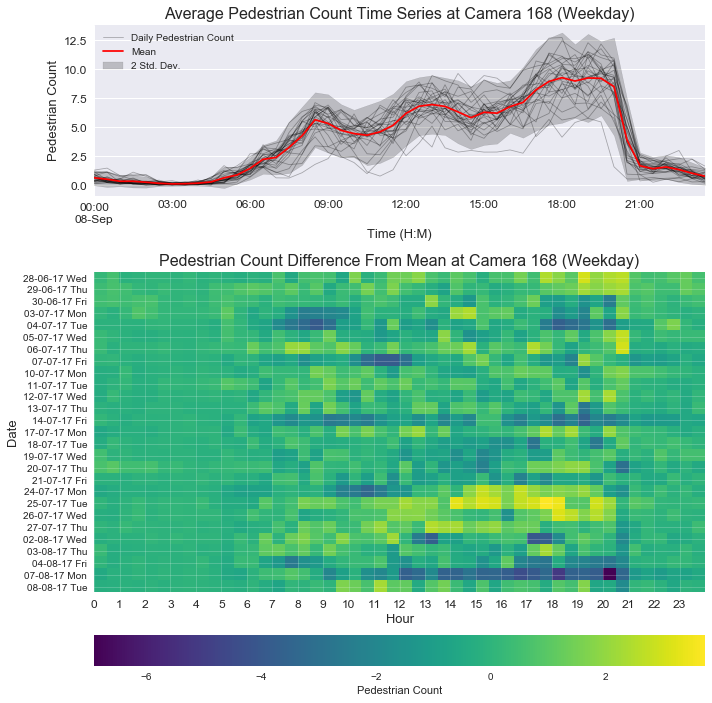

In [7]:
tmp = calc_daily_avg(df[(df.cam_id == 168) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])
plot_daily_avg(
    tmp,
    titles=("Average Pedestrian Count Time Series at Camera 168 (Weekday)",
            "Pedestrian Count Difference From Mean at Camera 168 (Weekday)"))

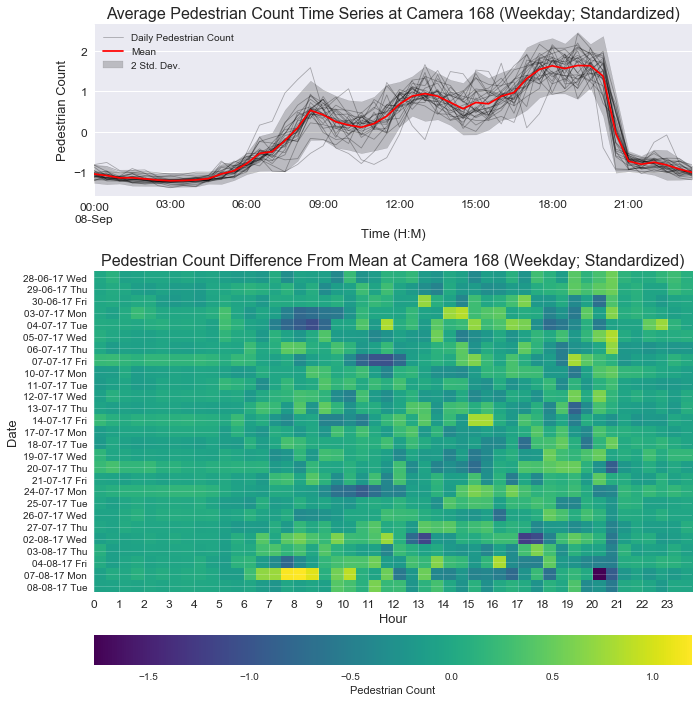

In [8]:
plot_daily_avg(
    tmp.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series at Camera 168 (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean at Camera 168 (Weekday; Standardized)"))

## Manhattan
### Weekday

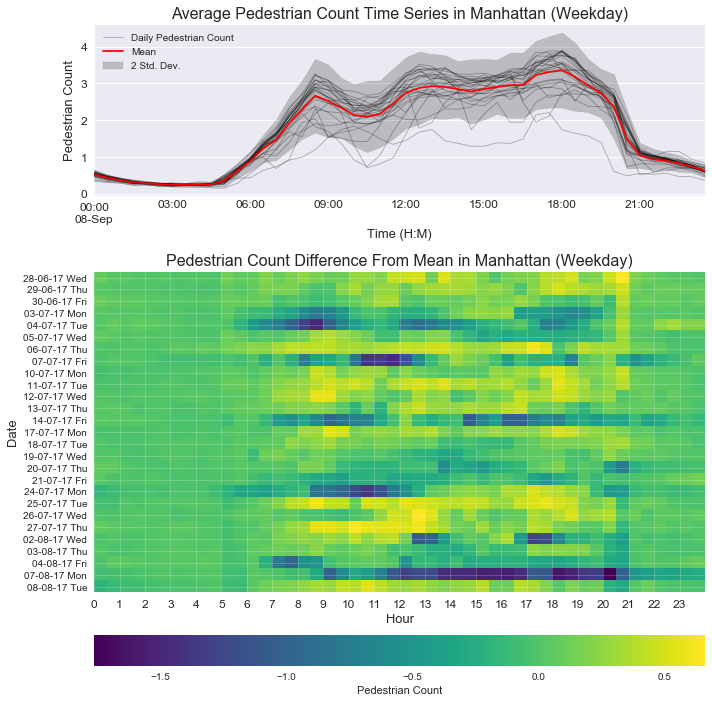

In [9]:
mn_wd = calc_daily_avg(df[(df.boro == "Manhattan") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    mn_wd,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekday)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekday)"))

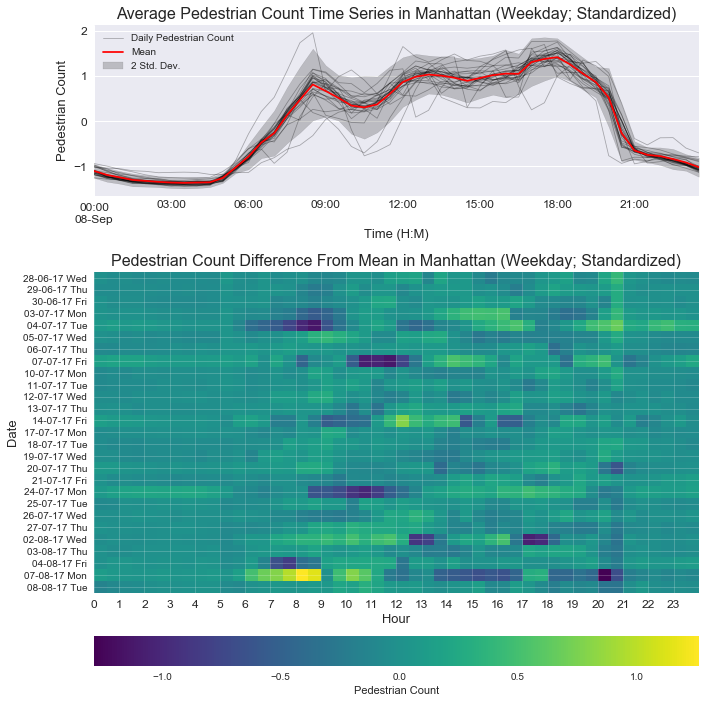

In [10]:
plot_daily_avg(
    mn_wd.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekday; Standardized)"))

### Weekend

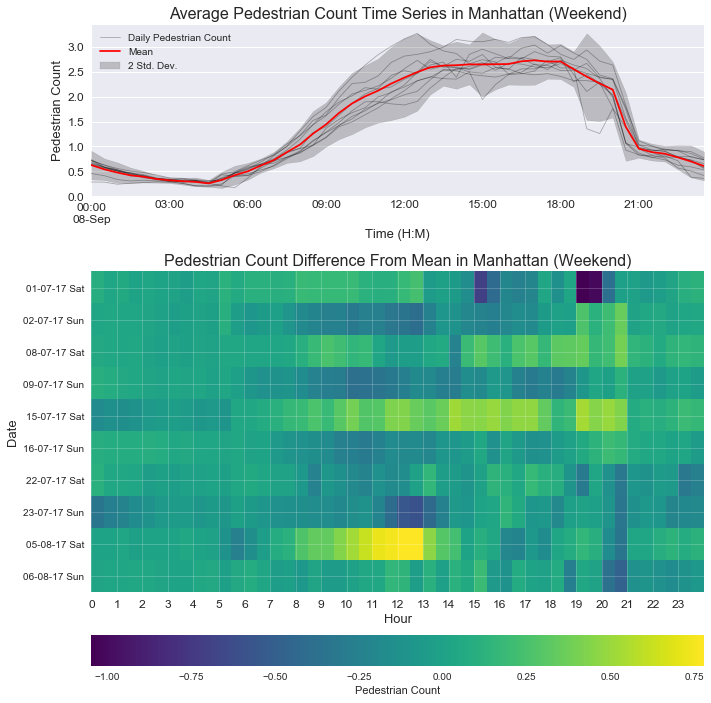

In [11]:
mn_we = calc_daily_avg(df[(df.boro == "Manhattan") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    mn_we,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekend)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekend)"))

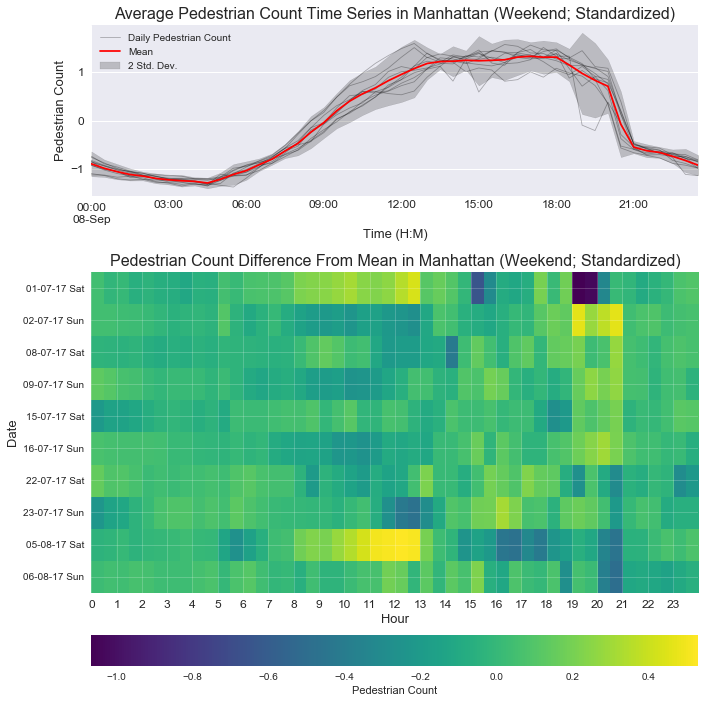

In [12]:
plot_daily_avg(
    mn_we.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Manhattan (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Manhattan (Weekend; Standardized)"))

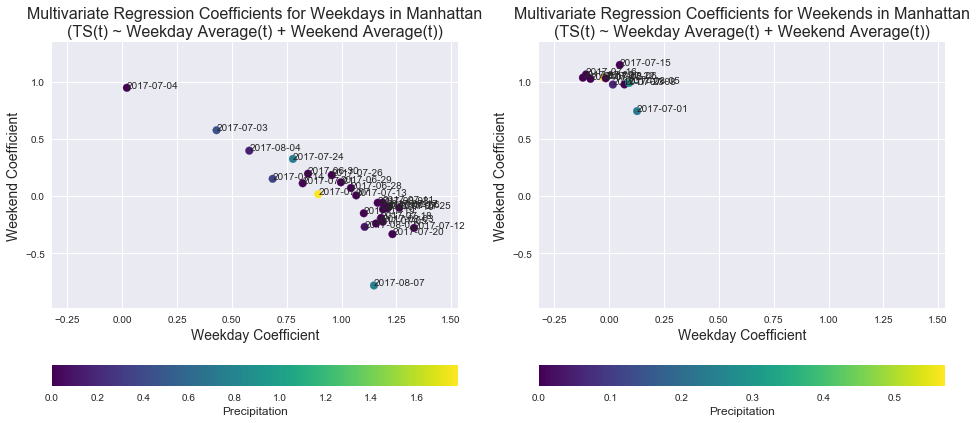

In [57]:
plot_reg_coefs(mn_wd, mn_we, prcp, "Manhattan")

## Brooklyn
### Weekday

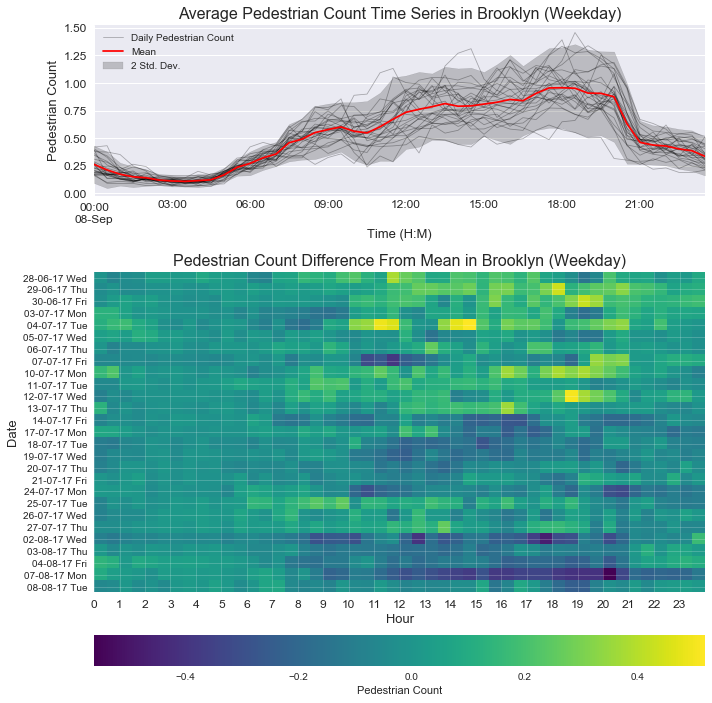

In [39]:
bk_wd = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    bk_wd,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekday)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekday)"))

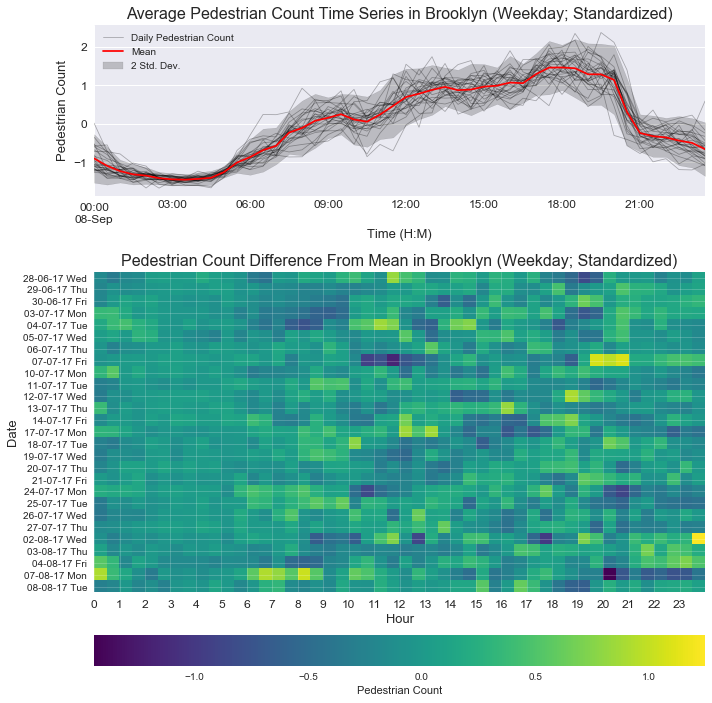

In [40]:
plot_daily_avg(
    bk_wd.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekday; Standardized)"))

### Weekend

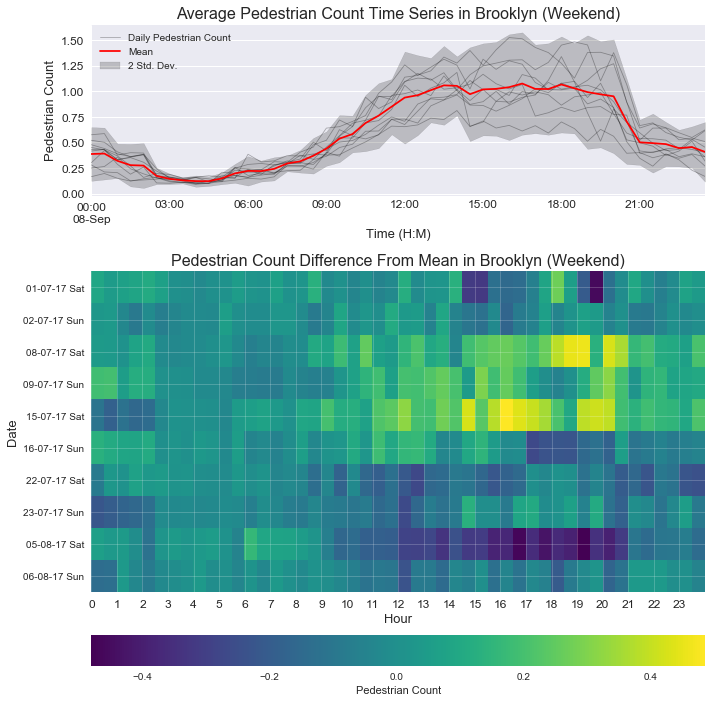

In [41]:
bk_we = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    bk_we,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekend)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekend)"))

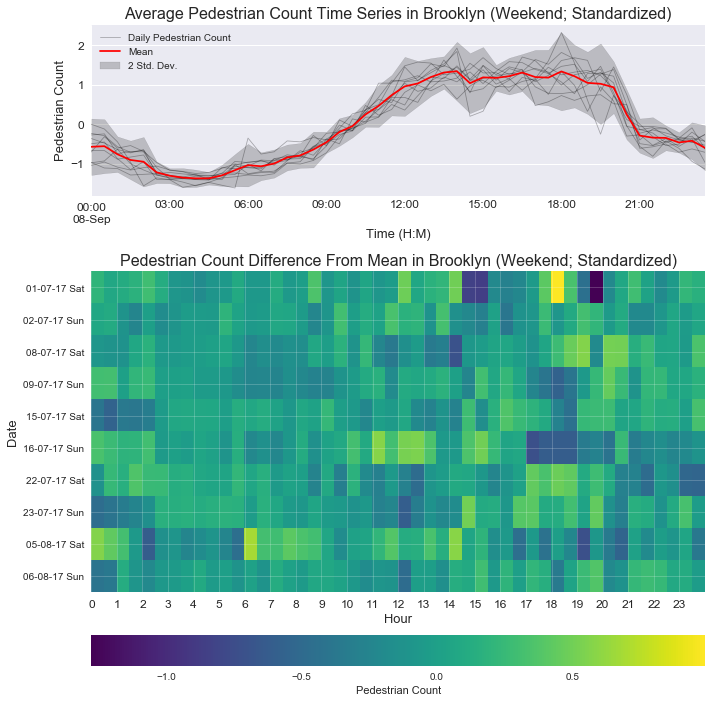

In [42]:
plot_daily_avg(
    bk_we.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Brooklyn (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Brooklyn (Weekend; Standardized)"))

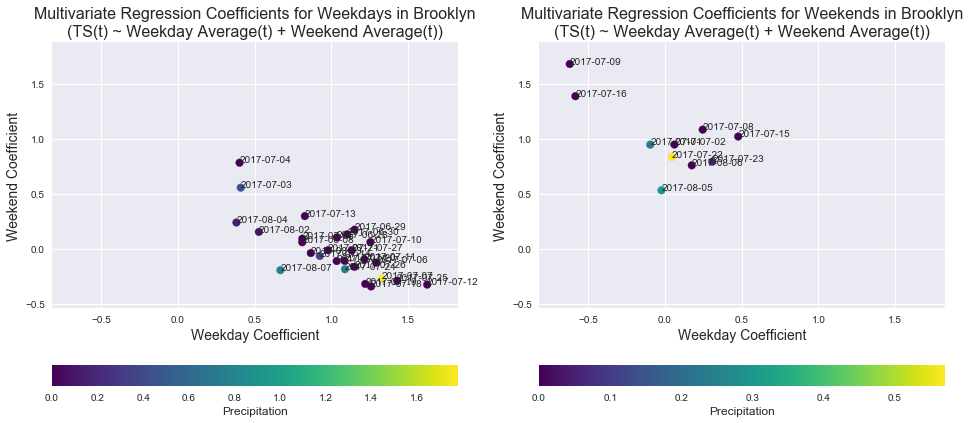

In [58]:
plot_reg_coefs(bk_wd, bk_we, prcp, "Brooklyn")

## Bronx
### Weekday

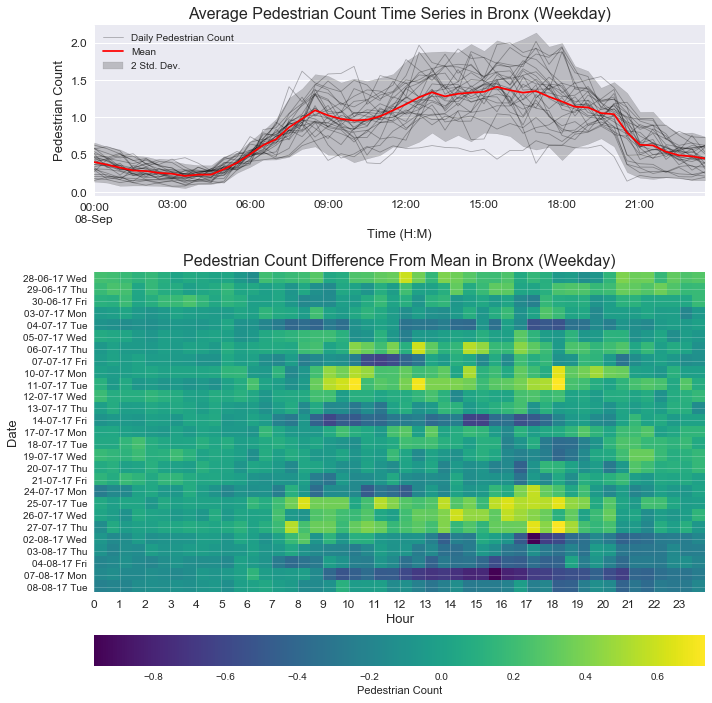

In [59]:
bx_wd = calc_daily_avg(df[(df.boro == "Bronx") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    bx_wd,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekday)",
            "Pedestrian Count Difference From Mean in Bronx (Weekday)"))

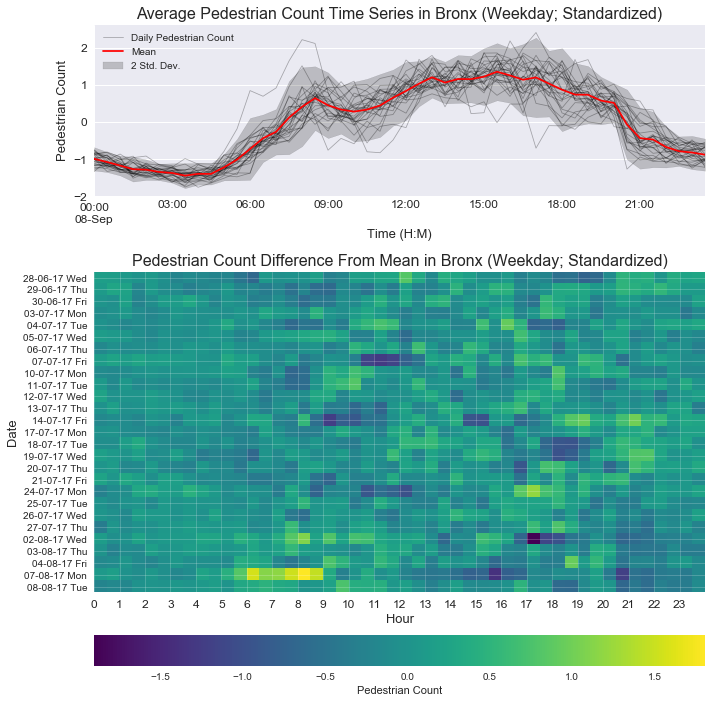

In [60]:
plot_daily_avg(
    bx_wd.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Bronx (Weekday; Standardized)"))

### Weekend

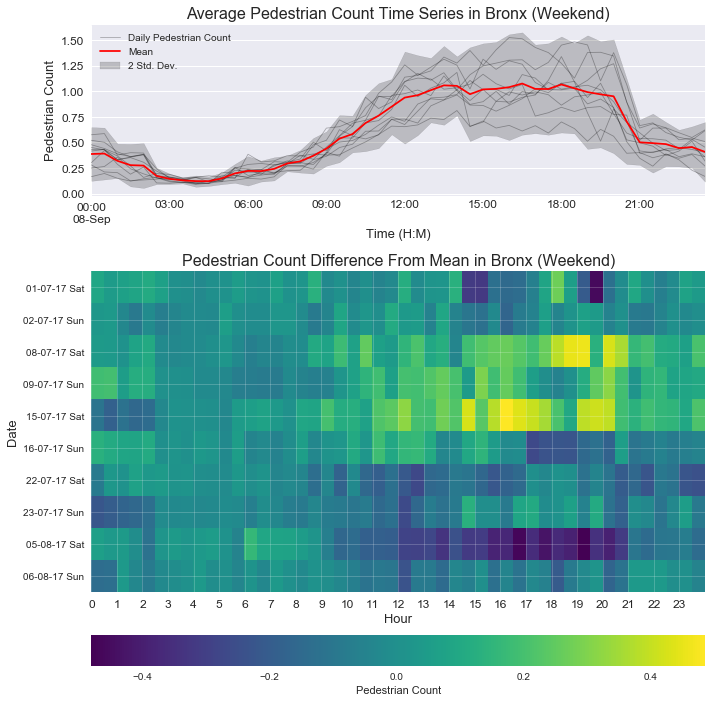

In [61]:
bx_we = calc_daily_avg(df[(df.boro == "Brooklyn") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    bx_we,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekend)",
            "Pedestrian Count Difference From Mean in Bronx (Weekend)"))

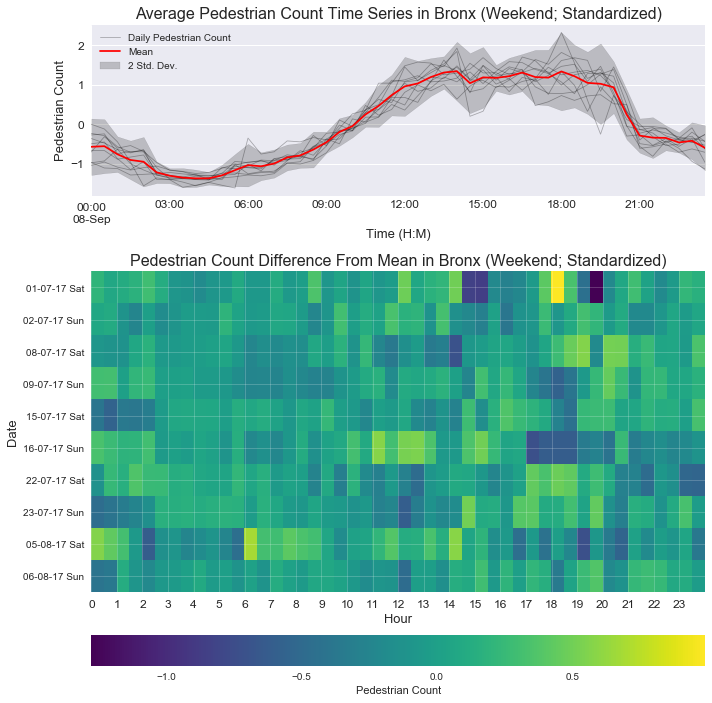

In [62]:
plot_daily_avg(
    bx_we.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Bronx (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Bronx (Weekend; Standardized)"))

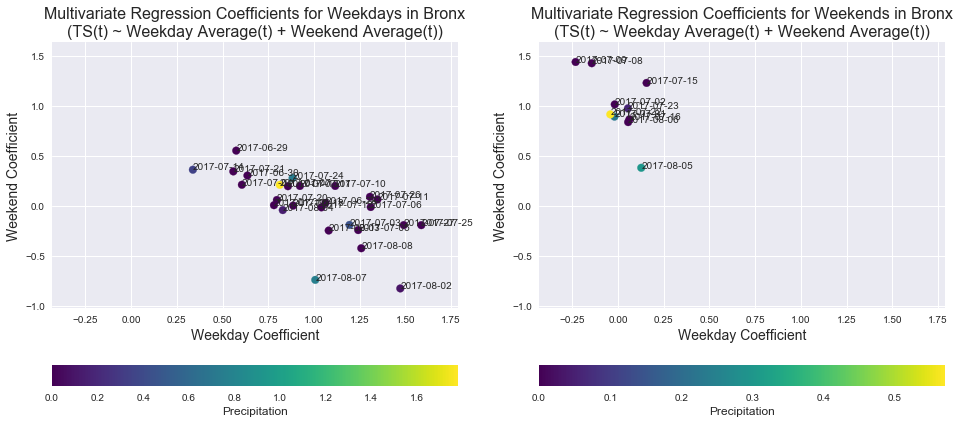

In [63]:
plot_reg_coefs(bx_wd, bx_we, prcp, "Bronx")

## Queens
### Weekday

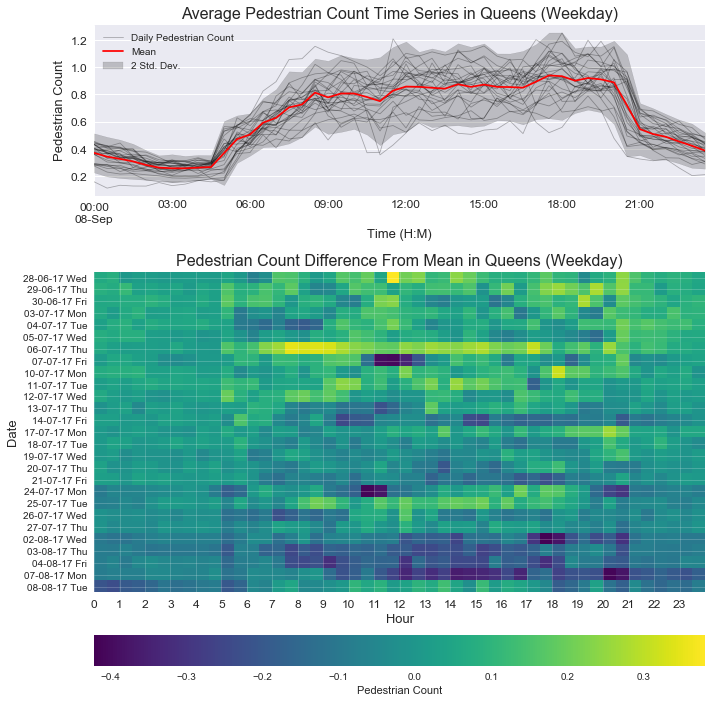

In [65]:
qn_wd = calc_daily_avg(df[(df.boro == "Queens") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    qn_wd,
    titles=("Average Pedestrian Count Time Series in Queens (Weekday)",
            "Pedestrian Count Difference From Mean in Queens (Weekday)"))

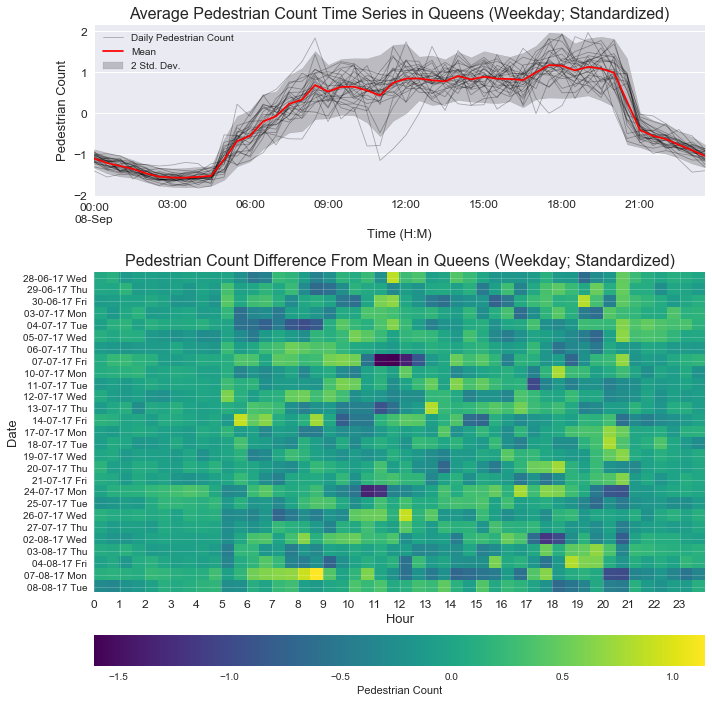

In [66]:
plot_daily_avg(
    qn_wd.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Queens (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Queens (Weekday; Standardized)"))

### Weekend

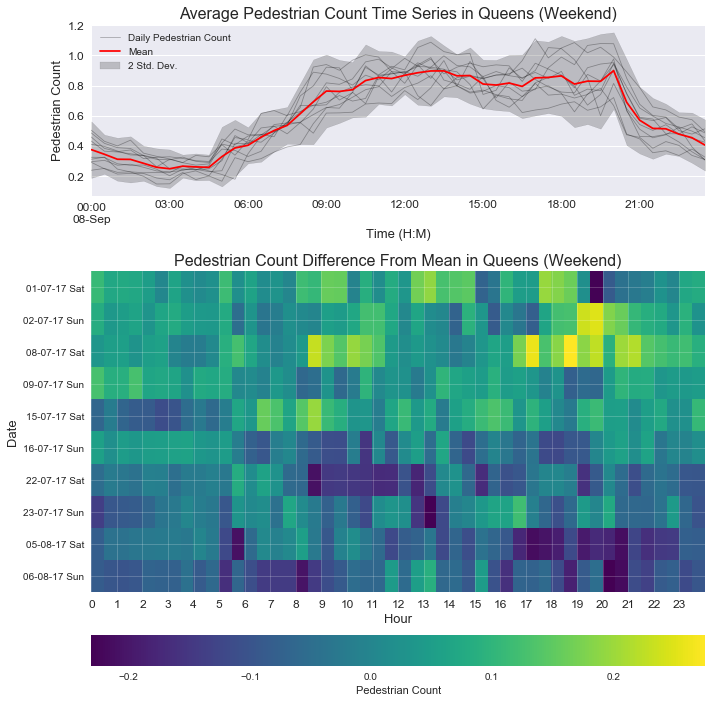

In [68]:
qn_we = calc_daily_avg(df[(df.boro == "Queens") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    qn_we,
    titles=("Average Pedestrian Count Time Series in Queens (Weekend)",
            "Pedestrian Count Difference From Mean in Queens (Weekend)"))

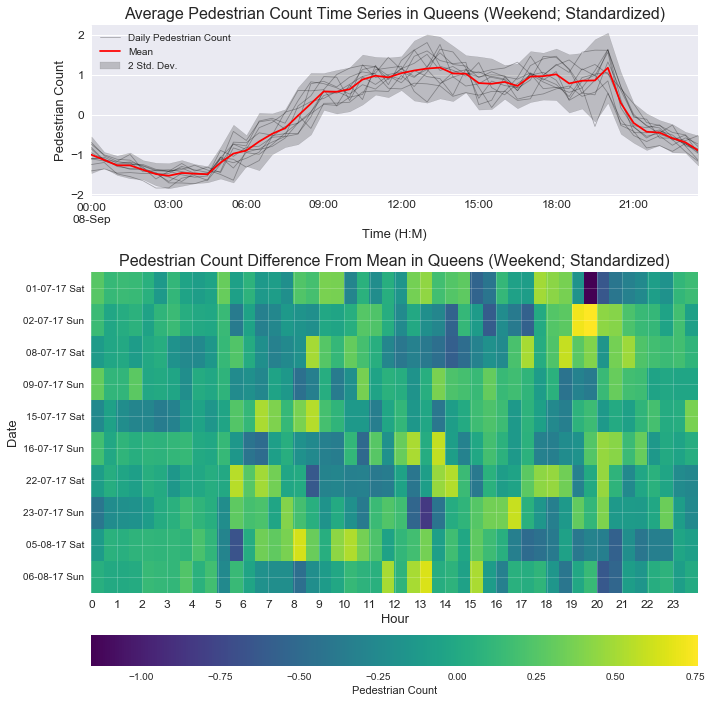

In [69]:
plot_daily_avg(
    qn_we.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Queens (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Queens (Weekend; Standardized)"))

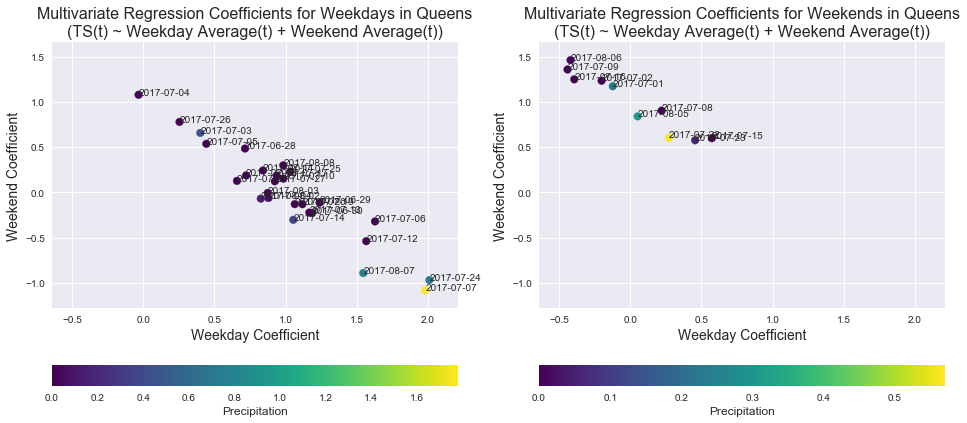

In [70]:
plot_reg_coefs(qn_wd, qn_we, prcp, "Queens")

## Staten Island
### Weekday

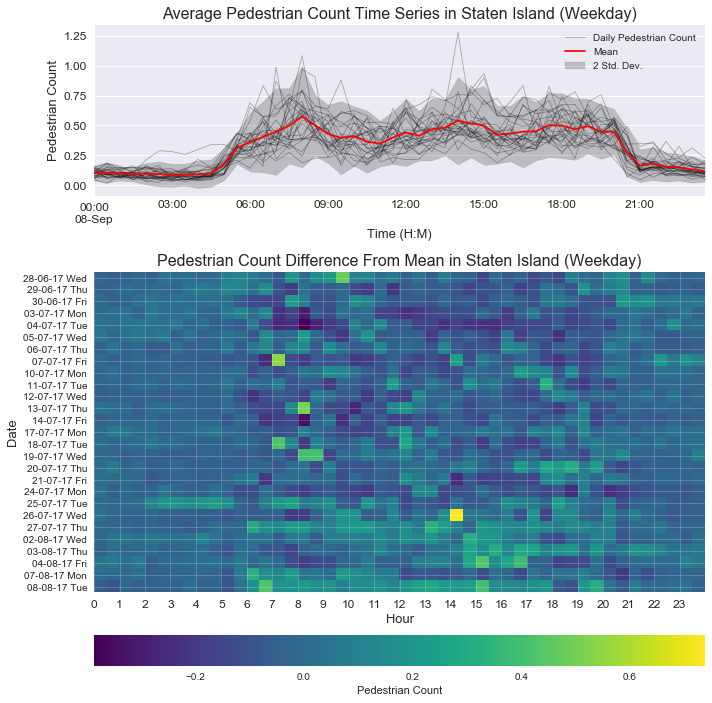

In [71]:
si_wd = calc_daily_avg(df[(df.boro == "Staten Island") & 
                        (df.people == 1.) & 
                        (df.index.weekday < 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    si_wd,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekday)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekday)"))

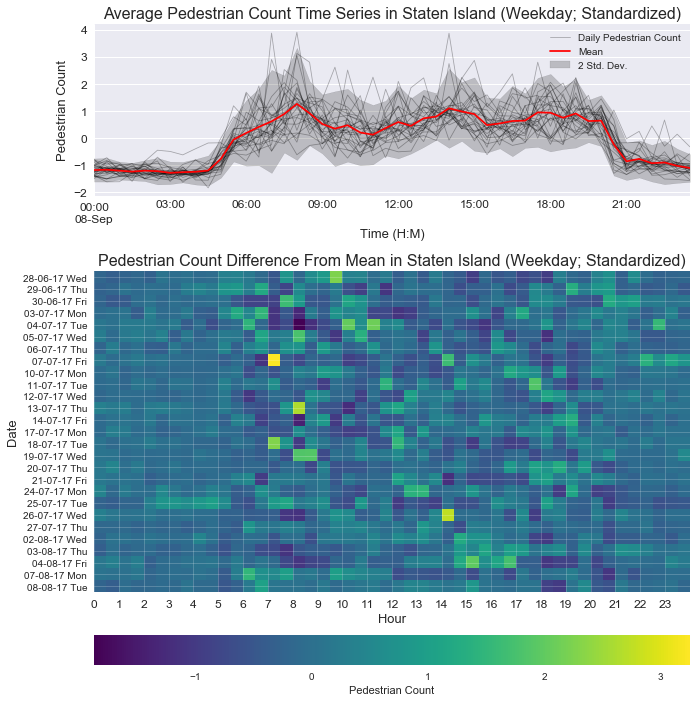

In [72]:
plot_daily_avg(
    si_wd.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekday; Standardized)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekday; Standardized)"))

### Weekend

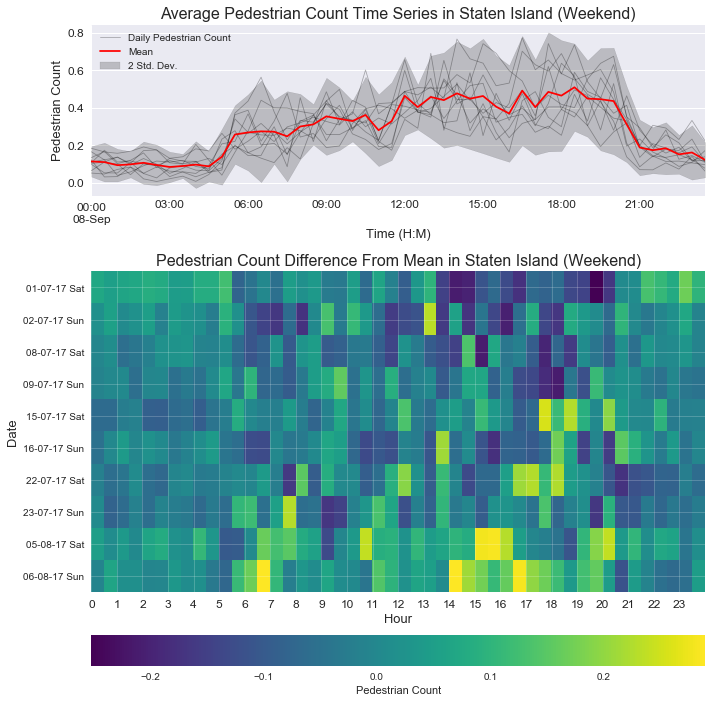

In [74]:
si_we = calc_daily_avg(df[(df.boro == "Staten Island") & 
                        (df.people == 1.) & 
                        (df.index.weekday >= 5) &
                        (df.index < pd.datetime(2017, 8, 9))])

plot_daily_avg(
    si_we,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekend)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekend)"))

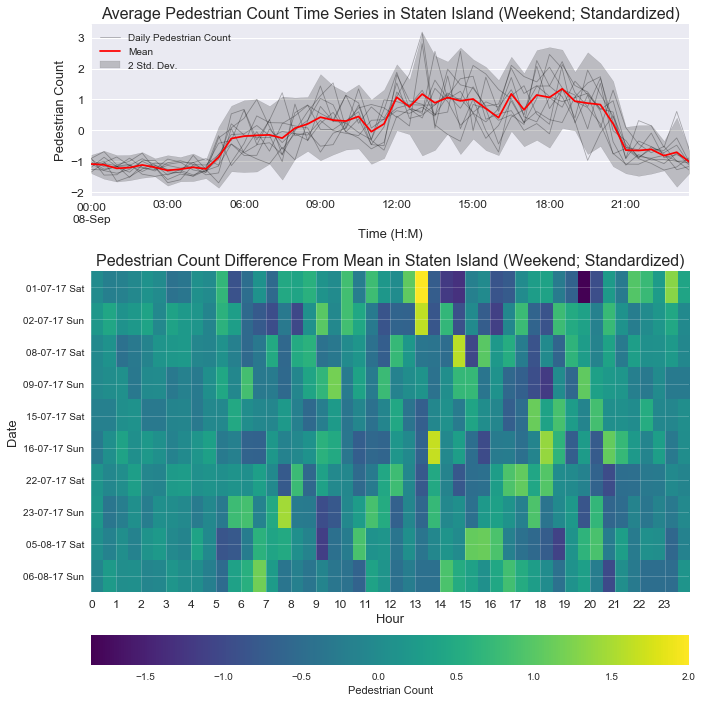

In [75]:
plot_daily_avg(
    si_we.T.apply(lambda x: (x - np.mean(x)) / (np.std(x))).T,
    titles=("Average Pedestrian Count Time Series in Staten Island (Weekend; Standardized)",
            "Pedestrian Count Difference From Mean in Staten Island (Weekend; Standardized)"))

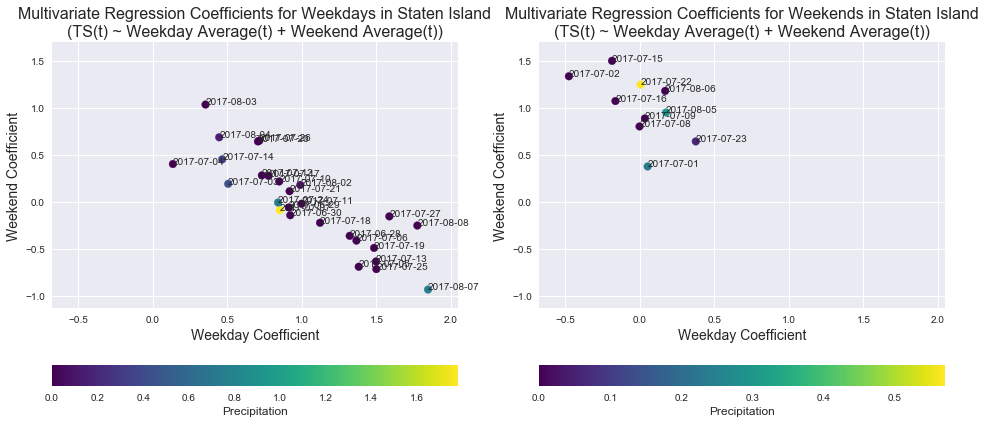

In [76]:
plot_reg_coefs(si_wd, si_we, prcp, "Staten Island")